# Deep Learning class exercise list 1

## Question 1

* ### Generating Data

In [859]:
import numpy as np
import matplotlib.pyplot as plt

In [860]:
def generate_data(data_size, train_val_split = 0.1):
    X = np.zeros((data_size, 3))
    y = np.zeros((data_size, 8))
    for i in range(data_size):
        arr = np.random.randint(0, 2, 3) + np.random.uniform(-0.1,0.1, 3)
        X[i] = np.round(arr,4)
        y[i][int(round(arr[0]) * 4 + round(arr[1]) * 2+ round(arr[2]))] = 1
    
    val_split = round(data_size * (1 - train_val_split))

    X_train, y_train = X[:val_split].T, y[:val_split].T
    X_val, y_val = X[val_split:].T, y[val_split:].T
    return X_train, X_val, y_train, y_val

In [861]:
def generate_data2(data_size, train_val_split = 0.1):
    X = np.zeros((data_size, 2))
    y = np.zeros((data_size, 1))
    for i in range(data_size):
        arr = np.random.randint(0, 2, 2) + np.random.uniform(-0.1,0.1, 2)
        X[i] = np.round(arr,4)
        y[i] = int(round(arr[0]) * 2 + round(arr[1]) * 1)
    
    val_split = round(data_size * (1 - train_val_split))
    X_train, y_train = X[:val_split].T, y[:val_split].T
    X_val, y_val = X[val_split:].T, y[val_split:].T
    return X_train, X_val, y_train, y_val

In [862]:
X_train, X_val, y_train, y_val = generate_data(50)

In [782]:
X_train.shape

(2, 4500)

In [783]:
y_train.shape

(1, 4500)

In [784]:
X_train.T

array([[ 1.0983,  1.0191],
       [ 1.0627,  0.9699],
       [ 1.0322,  0.9895],
       ...,
       [-0.0324, -0.067 ],
       [ 0.9398,  1.0794],
       [-0.0496, -0.0384]])

In [788]:
(y_train == 0).sum()

1139

In [789]:
(y_train == 1).sum()

1104

In [790]:
(y_train == 2).sum()

1071

In [791]:
(y_train == 3).sum()

1186

* ### MLP

In [792]:
def sigmoid(value):
    return 1/(1 + np.exp(-value))

def sigmoid_derivative(value):
    return sigmoid(value) * (1 - sigmoid(value))

In [793]:
def relu(value):
    return np.maximum(value, 0)

def relu_derivative(value):
    value[relu(value) <=0] = 0
    return value

In [817]:
def step_function(value):
    value = np.maximum(value, 0)
    value[value != 0] = 1
    return value

def step_derivative(value):
    return 1

In [863]:
class MLP():
    def __init__(self):
        self.parameters = {}
        self.cache = {}
        self.grads = {}

    def fit(self, X_train, y_train):
        """
        args : 
        X_train = input data of shape (n_x, number_of_examples)
        y_train = label vector of shape (n_y, number_of_examples)
        """
        self.X_train = (X_train - np.mean(X_train))/np.std(X_train)
        self.y_train = y_train
        self.m = X_train.shape[1]
        self.hidden = relu
        self.output = sigmoid

    def initialize_parameters(self, dims):
        self.L = len(dims)
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.random.randn(dims[l], dims[l-1]) * 0.01
            self.parameters["b" + str(l)] = np.zeros((dims[l], 1))
        return self.parameters
    
    def propagate(self):
        A_prev = self.X_train
        self.cache[f"A{0}"] = A_prev
        for l in range(1, self.L):
            
            Z = self.parameters[f"W{l}"] @ A_prev + self.parameters[f"b{l}"]
            #print(l)
            if l == self.L - 1:
                #print("sigmoid")
                A = self.output(Z)
            else:
                A = self.hidden(Z)

            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A
            
            A_prev = A
        
        self.y_hat = A

    def predict(self, X):
        A = X
        for l in range(1, self.L):
            Z = self.parameters[f"W{l}"] @ A + self.parameters[f"b{l}"]
            A = self.hidden(Z)
        
        return self.output(Z)
    
    def compute_diff(self):
        self.loss = - (np.divide(self.y_train, self.y_hat) - np.divide(1 - self.y_train, 1 - self.y_hat))
        #self.loss = self.y_hat - self.y_train
        #print(self.loss.shape)
        return self.loss
    
    def compute_grads(self):
        dZ = self.loss * sigmoid_derivative(self.cache[f"Z{self.L - 1}"])

        self.grads[f"dW{self.L - 1}"] = 1/self.m * dZ @ self.cache[f"A{self.L - 2}"].T
        self.grads[f"db{self.L - 1}"] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)
        
        for l in reversed(range(1, self.L - 1)):
            self.grads[f"dA_prev{l}"] = self.parameters[f"W{l + 1}"].T @ dZ
            dZ = self.grads[f"dA_prev{l}"] * relu_derivative(self.cache[f"Z{l}"])
            self.grads[f"dW{l}"] = 1/self.m * dZ @ self.cache[f"A{l - 1}"].T
            self.grads[f"db{l}"] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)
    
    def backprop(self, learning_rate = 0.001):
        self.learning_rate = learning_rate
        for l in reversed(range(1, self.L)):
            self.parameters["W"+str(l)] -= self.learning_rate * (self.grads[f"dW{l}"])
            self.parameters["b"+str(l)] -= self.learning_rate * (self.grads[f"db{l}"])

    def compute_cost(self):
        logprods = np.dot(self.y_train, np.log(self.y_hat).T) + np.dot((1-self.y_train), np.log(1- self.y_hat).T)
        cost = -1/self.m*np.sum(logprods)
        return cost#np.sum(self.loss)

    def train(self, dims, learning_rate = 0.001, iterations = 1000):
        printing_interval = round(iterations * 0.01)
        self.initialize_parameters(dims)
        costs = []
        for i in range(iterations):
            self.propagate()
            loss = self.compute_diff()
            costs.append(self.compute_cost())
            self.compute_grads()
            self.backprop(learning_rate = learning_rate)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

In [864]:
mlpclf = MLP()

In [865]:
mlpclf.fit(X_train, y_train)

$$
Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}
$$

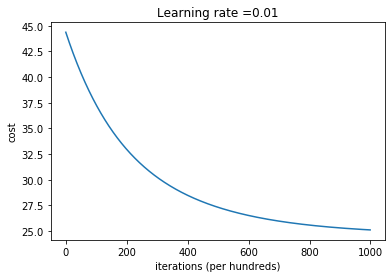

In [867]:
mlpclf.train([X_train.shape[0],8,y_train.shape[0]], learning_rate=0.01, iterations=1000)

In [868]:
y_pred = mlpclf.predict(X_val)

In [869]:
X_val.T[0:10]

array([[1.0394, 0.0128, 0.912 ],
       [0.9353, 0.9689, 1.0027],
       [0.0921, 0.9514, 0.9654],
       [0.9102, 0.0445, 1.0417],
       [0.0998, 0.0064, 0.0636]])

In [870]:
y_val.T[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

In [871]:
row_maxes = y_pred.T.max(axis=1).reshape(-1, 1)

In [875]:
np.argmax(y_pred, axis = 0)

array([1, 1, 1, 1, 1])

In [ ]:
np.argmax()

In [836]:
y_pred.T[0:10]

array([[0.02430398, 0.02721038, 0.12730349, 0.10091697, 0.11618435,
        0.11612583, 0.36595012, 0.60578228],
       [0.02529818, 0.09471432, 0.02499116, 0.1111794 , 0.10260876,
        0.45957196, 0.1141666 , 0.55454231],
       [0.01100546, 0.04472455, 0.06190308, 0.21853799, 0.06201709,
        0.20033145, 0.21005499, 0.78572326],
       [0.11120326, 0.11571927, 0.11763118, 0.1299759 , 0.10350705,
        0.12983408, 0.10771192, 0.13452459],
       [0.02745825, 0.03003761, 0.12694968, 0.10083202, 0.11678525,
        0.11717043, 0.34332783, 0.56382403]])